<a href="https://colab.research.google.com/github/oyjuffer/DL-Final/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL as pil
import tensorflow as tf

from data_augmentation import ImageGenerator

from tensorflow import keras
from keras.models import Sequential

from keras.layers import Activation, Convolution2D, Dropout, Conv2D, Rescaling, Dense
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os, shutil

random_seed = 40
keras.utils.set_random_seed(random_seed)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# # dataset directory.
# data_dir= "/content/drive/MyDrive/FER-2013/"

# Data loading + training/validation dataset split

In [2]:
data_dir= "emotion-detection-fer/"

### Data augmentation on the training dataset

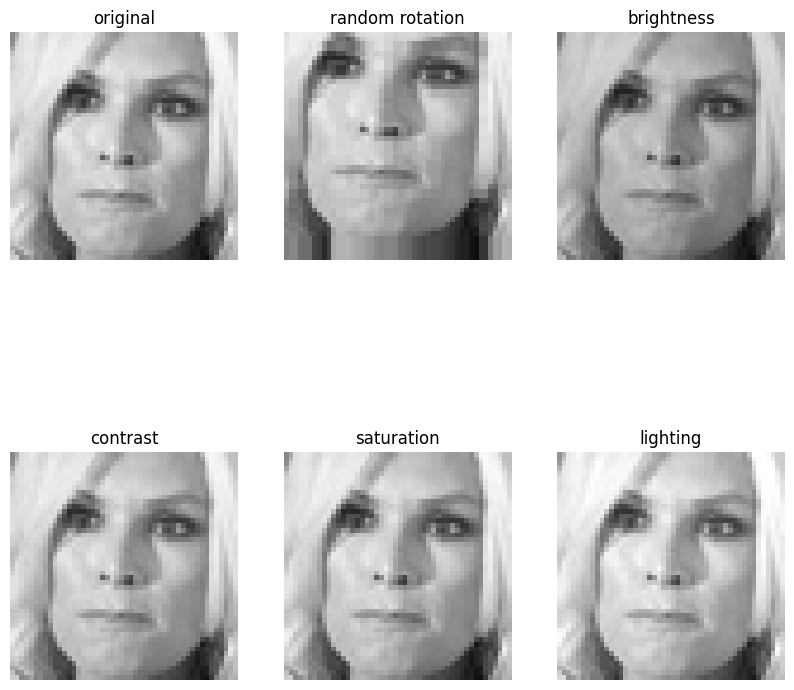

In [6]:
img_generator = ImageGenerator()

img = keras.utils.img_to_array(keras.utils.load_img(data_dir+"train_ext_copy/angry/Training_33331.jpg"))

new_imgs = [img_generator.do_random_rotation(img), img_generator.brightness(img), img_generator.contrast(img), 
            img_generator.saturation(img), img_generator.lighting(img)]

labels = ["original", "random rotation", "brightness", "contrast", "saturation", "lighting"]
plt.figure(figsize=(10, 10))
ii = 0
for image in [img] + new_imgs:
  ax = plt.subplot(2, 3, ii + 1)
  plt.imshow(image.astype("uint8"))
  plt.title(labels[ii])
  plt.axis("off")
  
  ii += 1

For each image in the train_ext_copy folder (80% of the original training folder), 6 new images are created per original image

In [4]:
img_generator = ImageGenerator()

# clears folder
for folder in os.listdir(data_dir+"train_ext/"):
  shutil.rmtree(data_dir+"train_ext/"+folder)

labels = ["original", "random rotation", "brightness", "contrast", "saturation", "lighting"]
# generates new images
for folder in os.listdir(data_dir+"train_ext_copy/"):
  os.mkdir(data_dir+"train_ext/"+folder)
  
  for img_name in os.listdir(data_dir+"train_ext_copy/"+folder):
    img_path = data_dir+"train_ext_copy/"+folder+"/"+img_name
    img = keras.utils.img_to_array(keras.utils.load_img(img_path))
    new_imgs = [img_generator.do_random_rotation(img), img_generator.brightness(img), img_generator.contrast(img), 
            img_generator.saturation(img), img_generator.lighting(img)]
    
    ii = 0
    for image in [img] + new_imgs:
      img_keras = keras.utils.array_to_img(image)
      new_img_name = "{}_{}.jpg".format(img_name.replace(".jpg", ""), labels[ii])
      img_keras.save(data_dir+"train_ext/"+folder+"/"+new_img_name)
      ii+=1
    

If ext_flag=0, then the 80/20 % of the original train folder are used for training validation, while if ext_flag=1, then it is used an augmented version of the training data

In [42]:
image_size = 48 # 48x48 gray scale images
batch_size = 32 # default batch size

ext_flag=1

if ext_flag:

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "train_ext/",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='grayscale')
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "val_ext/",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='grayscale')
  
else:
  
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "train/",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='grayscale')

  train_ds, val_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8, seed=random_seed)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + "test/",
  image_size=(image_size, image_size),
  batch_size=batch_size,
  color_mode='grayscale')

Found 137808 files belonging to 7 classes.
Found 5741 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


### Analyze datasets

In [10]:
def print_ds_inf(ds, case=""):
    n_classes = 7 # 7 different expressions
    n_per_class = np.zeros(n_classes)
    
    for element in ds.as_numpy_iterator():
        labels = element[1]
        for lab in labels:
            n_per_class[lab] += 1
    n_total = np.sum(n_per_class)
    
    print(case+" -> Total: {}, Per_class: {}".format(n_total, n_per_class))
        
print_ds_inf(train_ds, "Train")
print_ds_inf(val_ds, "Validation")
print_ds_inf(test_ds, "Test")

Train -> Total: 22967.0, Per_class: [3182.  341. 3263. 5807. 3967. 3854. 2553.]
Validation -> Total: 5742.0, Per_class: [ 813.   95.  834. 1408.  998.  976.  618.]
Test -> Total: 7178.0, Per_class: [ 958.  111. 1024. 1774. 1233. 1247.  831.]


In [11]:
class_names = test_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


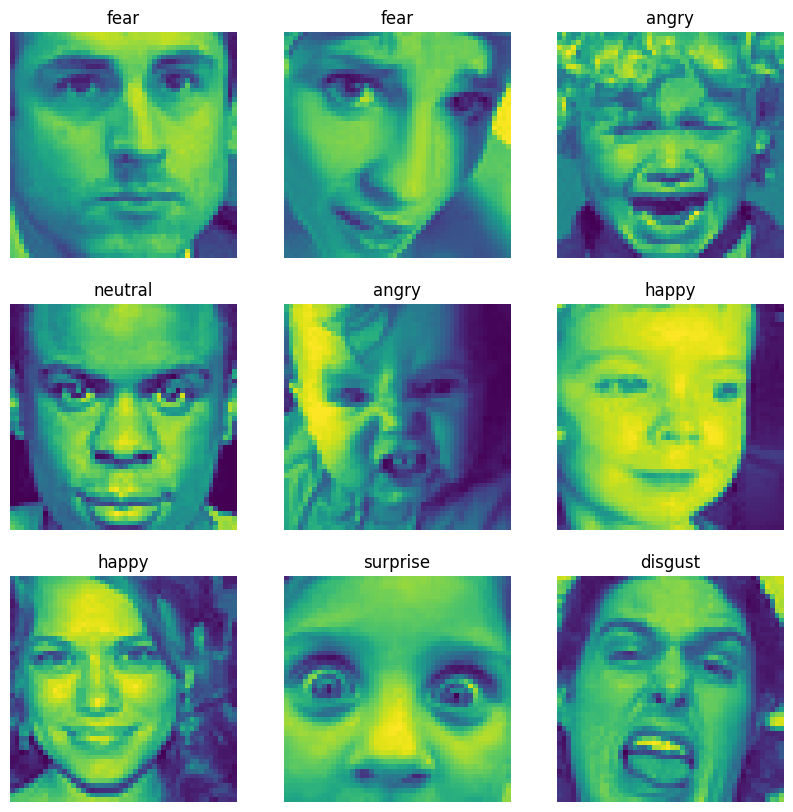

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# CNN arquitectures

In [18]:
num_classes = len(class_names)

model = Sequential(name="Default-preliminary")
model.add(Rescaling(1./255, input_shape=(image_size, image_size, 1))) # images are in the range [0 255]

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # labels are provided as integers
  metrics=['accuracy']) # computes the accuracy

Model: "Default-preliminary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)

In [54]:
num_classes = len(class_names)

model = Sequential(name="Default-preliminary")
model.add(Rescaling(1./255, input_shape=(image_size, image_size, 1))) # images are in the range [0 255]

model.add(Conv2D(filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=32, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # labels are provided as integers
  metrics=['accuracy']) # computes the accuracy

# Epoch 43/100
# 718/718 [==============================] - 51s 71ms/step - loss: 0.7987 - accuracy: 0.6969 - val_loss: 1.0885 - val_accuracy: 0.5935
# [1.0848079919815063, 0.6021175980567932

Model: "Default-preliminary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_58 (Conv2D)          (None, 48, 48, 16)        416       
                                                                 
 batch_normalization_60 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_59 (Conv2D)          (None, 48, 48, 16)        6416      
                                                                 
 batch_normalization_61 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 activation_45 (Activation)  (None, 48, 48, 16)

In [16]:
num_classes = len(class_names)

model = Sequential(name="Default-preliminary")
model.add(Rescaling(1./255, input_shape=(image_size, image_size, 1))) # images are in the range [0 255]

model.add(Conv2D(filters=16, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
# model.add(Dropout(rate=0.1))

model.add(SeparableConv2D(filters=32, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
# model.add(Dropout(rate=0.1))

model.add(SeparableConv2D(filters=128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
# model.add(Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # labels are provided as integers
  metrics=['accuracy']) # computes the accuracy

# 718/718 [==============================] - 50s 69ms/step - loss: 0.9222 - accuracy: 0.6529 - val_loss: 1.1301 - val_accuracy: 0.5874


Model: "Default-preliminary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d_3 (Averag  (None, 24, 24, 16)       0         
 ePooling2D)                                                     
                                                                 
 separable_conv2d (Separable  (None, 24, 24, 32

### Training function + basic visualization/storage

In [52]:
def train_model(model, train=train_ds, validation=val_ds, epochs=10, patience=4, workers=4):
  early_stop = EarlyStopping(monitor="val_loss", patience=patience)
  reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/2), verbose=1, min_lr=0.0001)
  
  
  callbacks = [early_stop]

  history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=epochs,
    workers=workers
  )
  
  return history

In [59]:
history = train_model(model, epochs=20, patience=4)

Epoch 1/20
4307/4307 [==============================] - 627s 146ms/step - loss: 0.8723 - accuracy: 0.6727 - val_loss: 1.0960 - val_accuracy: 0.6049
Epoch 2/20
4307/4307 [==============================] - 578s 134ms/step - loss: 0.8549 - accuracy: 0.6807 - val_loss: 1.1101 - val_accuracy: 0.6022
Epoch 3/20
4307/4307 [==============================] - 578s 134ms/step - loss: 0.8388 - accuracy: 0.6878 - val_loss: 1.1023 - val_accuracy: 0.6161
Epoch 4/20
4307/4307 [==============================] - 548s 127ms/step - loss: 0.8260 - accuracy: 0.6913 - val_loss: 1.1189 - val_accuracy: 0.6056
Epoch 5/20
4307/4307 [==============================] - 546s 127ms/step - loss: 0.8063 - accuracy: 0.7017 - val_loss: 1.1154 - val_accuracy: 0.6077


In [56]:
model.save("cnn_trained_ext_dataset_dropout", overwrite=True)

INFO:tensorflow:Assets written to: cnn_trained_ext_dataset_dropout\assets


INFO:tensorflow:Assets written to: cnn_trained_ext_dataset_dropout\assets


In [61]:
test_loss, test_acc = model.evaluate(test_ds)

225/225 [==============================] - 7s 29ms/step - loss: 1.0999 - accuracy: 0.6089


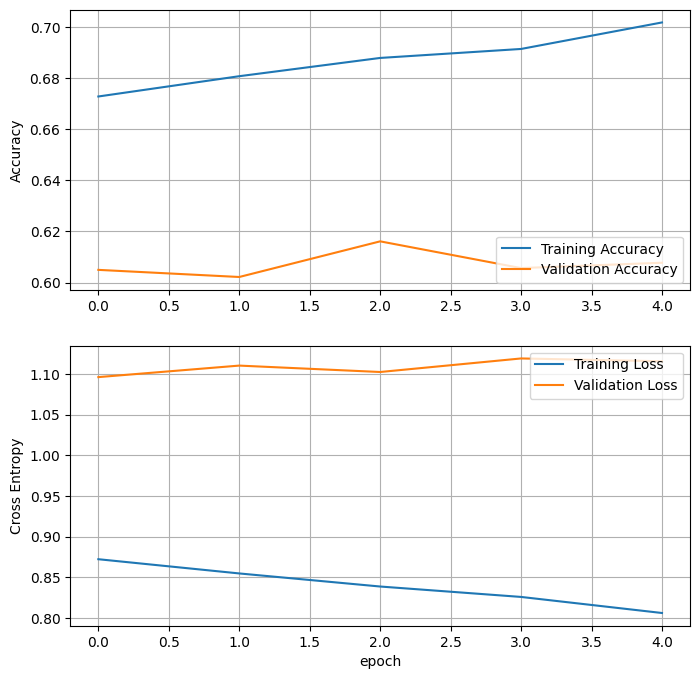

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.grid()
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.title('Training and Validation Loss')
plt.grid()
plt.xlabel('epoch')

plt.savefig('ext_dataset_dropout2.png')
plt.savefig('ext_dataset_dropout2.eps')

plt.show()
